# METEK Sonic3D data downloading and plotting for Argonne Deployable Mast
Notebook shows data procesign for METEK `uSonic` 3D anemometer deployed on the Argonne Deployable Mast (ADM). It automates the process of downloading data, converting it to NetCDF format, and generating plots. The notebook includes querying data from the beehive and provide a streamlined workflow for accessing, processing, and visualizing sonic anemometer data from the CROCUS ADM.

## Imports

In [1]:
import sage_data_client
import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import os

## GPS location for ADM
We will first write function to get the GPS data from the Node for ADM

In [2]:
def get_gps_location(date, vsn):
    start_time = f"{date}T00:00:00Z"
    end_time = f"{date}T23:59:59Z"

    gps_data = sage_data_client.query(
        start=start_time,
        end=end_time,
        #start = "-5h",
        filter={
            "name": "sys.gps.lat|sys.gps.lon",
            "vsn": "W09E"
            }
    )

    if gps_data.empty:
        print("No GPS data found.")
        return None, None
    # we got error when data was not in correct types so use try catch
    try:
        values = gps_data.groupby("name").value.median()
        lat = values.get("sys.gps.lat")
        lon = values.get("sys.gps.lon")
    except:
        print("Error in GPS data")
        return None, None

    return lat, lon


In [3]:
get_gps_location("2024-07-23", "W09E")

(41.867577374, -87.649569349)

### Define global metadata attributes for NetCDF file

In [4]:
def get_global_attrs(date, vsn, station_name, site_name, plugin):
    gps_lat, gps_lon = get_gps_location(date, vsn)
    global_attrs = {
        "site_name": site_name,
        "altitude": "185",
        "latitude": str(gps_lat) if gps_lat else "NA",
        "longitude": str(gps_lon) if gps_lon else "NA",
        "station_name": station_name,
        "plugin": plugin,
        "vsn": vsn,
        "acquisition_software": "Sage-Waggle",
        "acquisition_frequency": "20.0Hz",  
        "instr_1_manufacturer": "metek",
        "instr_1_model": "Usonic3 Class A MP",
        "instr_name": "uSonic3d",
        "data_contact": "Bhupendra Raut <braut@anl.gov>",
        "inst_contact": "Sujan Pal <spal@anl.gov>",
        "source": "CROCUS Measurement Strategy Team",
        "project": "CROCUS - an Urban Integrated Field Laboratory",
        "data_policy": "Open data, adheres to FAIR principles (Findable, Accessible, Interoperable, Reusable)",
        "institution": "Argonne National Laboratory",
        "funding_source": "U.S. DOE Office of Science, Biological and Environmental Research program",
        "acknowledgment": (
            "This material is based upon work supported by the U.S. Department of Energy, "
            "Office of Science, Office of Biological and Environmental Research’s Urban Integrated "
            "Field Laboratories CROCUS project research activity, under Contract Number DE-AC02-06CH11357 "
            "and Award Number DE-SC0023226."
        ),
        "file_creation_date": datetime.now().replace(tzinfo=None).strftime("%Y-%m-%d"),
        "data_version": "v1.0.0",
        "file_version": "2025.02.10",
        "instrument_date": date,
    }
    return global_attrs

### Process data for given period

In [5]:
def process_data_for_period(start_time, end_time, out_dir, global_attrs):
    vsn = global_attrs["vsn"]
    plugin = global_attrs["plugin"]

    df = sage_data_client.query(start=start_time, end=end_time, filter={"vsn": vsn, "plugin": plugin})

    if df.empty:
        print(f"No data found for {start_time} to {end_time} - Skipping...")
        return

    # Convert timestamp to CF-compliant format (nanoseconds since 1970-01-01)
    time_base = pd.Timestamp("1970-01-01T00:00:00", tz="UTC")

    # Sage timestamps are tUTC
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

    # Round timestamps to the nearest 2 milliseconds (2000 µs) to align high-frequency data
    df["rounded_timestamp"] = df["timestamp"].dt.round("3000us")

    # Clean variable names (remove "sonic3d.")
    df["name"] = df["name"].str.replace("sonic3d.", "", regex=False)

    # Pivot after rounding timestamps
    df_pivot = df.pivot(columns="name", values="value")

    # Group by rounded timestamps and aggregate using mean() (averages multiple readings)
    df_pivot = df_pivot.groupby(df["rounded_timestamp"]).mean()

    # Reset index and rename "rounded_timestamp" to "time"
    df_pivot = df_pivot.reset_index().rename(columns={"rounded_timestamp": "time"})

    # Convert time to nanoseconds since epoch (int64)
    df_pivot["time"] = (df_pivot["time"] - time_base).astype("int64")

    # Extract metadata
    metadata = df.drop_duplicates(subset=["name"]).set_index("name")["meta.description"].to_dict()
    units = df.drop_duplicates(subset=["name"]).set_index("name")["meta.units"].to_dict()

    # Create Xarray Dataset
    ds = xr.Dataset()

    # Add time variable (CF-compliant format)
    ds["time"] = ("time", df_pivot["time"].values.astype(np.int64))  # Store as int64 nanoseconds
    ds["time"].attrs["units"] = "nanoseconds since 1970-01-01 00:00:00 UTC"
    ds["time"].attrs["long_name"] = "Time in nanoseconds since epoch"
    ds["time"].attrs["standard_name"] = "time"

    # Add sensor variables
    for var in df_pivot.columns.drop(["time"], errors="ignore"):
        ds[var] = ("time", df_pivot[var].values.astype(np.float32))
        ds[var].attrs["long_name"] = metadata.get(var, "")
        ds[var].attrs["units"] = units.get(var, "")

    # Add global attributes
    ds.attrs.update(global_attrs)

    # Save to NetCDF
    site_name = global_attrs["site_name"]
    station_name = global_attrs["station_name"]
    instr_name = global_attrs["instr_name"]
    # Format date and time for CROCUS standards
    date_part = start_time[:10].replace("-", "")  # YYYYMMDD
    hour_part = start_time[11:13] + "0000"  # HH0000


    out_dir = f"{out_dir}{station_name}_{site_name}/"
    os.makedirs(out_dir, exist_ok=True)
    filename = f"{out_dir}{station_name}-{site_name}-{instr_name}-a1-{date_part}-{hour_part}.nc"
    ds.to_netcdf(filename, format="NETCDF4", engine="netcdf4", encoding={var: {"zlib": True, "complevel": 2} for var in ds.data_vars})

    print(f"Saved {filename}")


### Run the processing for all Dates

In [6]:
def get_sonic_data(out_dir, global_attrs):
    date = global_attrs["instrument_date"]
    for hour in range(24):
        try:
            start_time = f"{date}T{hour:02d}:00:00Z"
            end_time = f"{date}T{hour:02d}:59:59Z"
            process_data_for_period(start_time, end_time, out_dir, global_attrs)
        except:
            print(f"Error in processing data for {start_time} - Skipping...")
            continue

    print("Processing complete!")


### Define input for the main function

In [7]:
start_date = "2024-07-23"
end_date = "2024-07-30"
out_dir = "/Users/bhupendra/projects/crocus/data/IOP/"

vsn = "W09E"
plugin = "10.31.81.1:5000/local/plugin-metek-sonic3d-sampler"

station_name = "crocus-ADM"
site_name = "UIC-IOP"
# Generate date range
start = datetime.strptime(start_date, "%Y-%m-%d")
end = datetime.strptime(end_date, "%Y-%m-%d")
date_range = [start + timedelta(days=x) for x in range((end - start).days + 1)]

# Process data for each day
for date_obj in date_range:
    date = date_obj.strftime("%Y-%m-%d")
    print(f"Processing data for {date}...")
    global_attrs = get_global_attrs(date, vsn, station_name, site_name, plugin)
    get_sonic_data(out_dir, global_attrs)

print("All processing complete!")

Processing data for 2024-07-23...
No data found for 2024-07-23T00:00:00Z to 2024-07-23T00:59:59Z - Skipping...
No data found for 2024-07-23T01:00:00Z to 2024-07-23T01:59:59Z - Skipping...
Saved /Users/bhupendra/projects/crocus/data/IOP/crocus-ADM_UIC-IOP/crocus-ADM-UIC-IOP-uSonic3d-a1-20240723-020000.nc
Saved /Users/bhupendra/projects/crocus/data/IOP/crocus-ADM_UIC-IOP/crocus-ADM-UIC-IOP-uSonic3d-a1-20240723-030000.nc
Saved /Users/bhupendra/projects/crocus/data/IOP/crocus-ADM_UIC-IOP/crocus-ADM-UIC-IOP-uSonic3d-a1-20240723-040000.nc
Saved /Users/bhupendra/projects/crocus/data/IOP/crocus-ADM_UIC-IOP/crocus-ADM-UIC-IOP-uSonic3d-a1-20240723-050000.nc
Saved /Users/bhupendra/projects/crocus/data/IOP/crocus-ADM_UIC-IOP/crocus-ADM-UIC-IOP-uSonic3d-a1-20240723-060000.nc
Saved /Users/bhupendra/projects/crocus/data/IOP/crocus-ADM_UIC-IOP/crocus-ADM-UIC-IOP-uSonic3d-a1-20240723-070000.nc
Saved /Users/bhupendra/projects/crocus/data/IOP/crocus-ADM_UIC-IOP/crocus-ADM-UIC-IOP-uSonic3d-a1-20240723-080

## Plot

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import folium
from IPython.display import IFrame

### Plot location on the map
Because the ADM is not long term deployment we need to get the location of deployment. If any of the files above have different location than deployment then we should remove that file from the analysis. So let check if there are any outlier locations on the map.

In [12]:
def plot_lat_lon_with_folium(netcdf_dir, output_html="map.html"):
    # Get a list of all NetCDF files in the directory
    netcdf_files = glob.glob(os.path.join(netcdf_dir, "*.nc"))
    
    latitudes = []
    longitudes = []

    # Read latitude and longitude from each file
    for file in netcdf_files:
        try:
            ds = xr.open_dataset(file)
            latitude = float(ds.attrs.get("latitude", None))
            longitude = float(ds.attrs.get("longitude", None))
            
            if latitude is not None and longitude is not None:
                latitudes.append(latitude)
                longitudes.append(longitude)
        except Exception as e:
            print(f"Error reading {file}: {e}")
        finally:
            ds.close()

    # Check if we have valid lat/lon data
    if not latitudes or not longitudes:
        print("No valid latitude/longitude data found.")
        return

    # Create a folium map centered at the mean latitude and longitude
    map_center = [sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)]
    folium_map = folium.Map(location=map_center, zoom_start=6)

    # Add points to the map
    for lat, lon in zip(latitudes, longitudes):
        folium.Marker(location=[lat, lon], popup=f"Lat: {lat}, Lon: {lon}").add_to(folium_map)

    # Save the map to an HTML file
    folium_map.save(output_html)
    print(f"Map saved to {output_html}")
    return folium_map

# Example usage
netcdf_dir = "/Users/bhupendra/projects/crocus/data/IOP/crocus-ADM_UIC-IOP/"
plot_lat_lon_with_folium(netcdf_dir)

Map saved to map.html


## Now plot the actual data


In [15]:
file_path = "/Users/bhupendra/projects/crocus/data/IOP/CROCUS-ADM_UIC-IOP/*20240727*.nc"
files = glob.glob(file_path)
ds = xr.open_mfdataset(files)

# Convert time to datetime
time = pd.to_datetime(ds['time'].values)

# Create a DataFrame
df = pd.DataFrame({
    'time': time,
    'temp': ds['temp'].values,
    'uwind': ds['uwind'].values,
    'vwind': ds['vwind'].values,
    'wwind': ds['wwind'].values
})
df

,time,temp,uwind,vwind,wwind
0,2024-07-27 00:00:00.021,23.666000,-1.677,-0.222,-0.576
1,2024-07-27 00:00:00.054,23.650999,-1.920,-0.116,-0.454
2,2024-07-27 00:00:00.087,23.645000,-2.281,0.142,-0.035
3,2024-07-27 00:00:00.120,23.705999,-2.578,0.167,0.071
4,2024-07-27 00:00:00.153,NaN,-2.612,-0.062,NaN
...,...,...,...,...,...
3199510,2024-07-27 23:59:58.899,25.697001,NaN,NaN,-0.547
3199511,2024-07-27 23:59:58.929,NaN,-2.586,NaN,NaN
3199512,2024-07-27 23:59:58.932,25.663000,NaN,0.888,-0.585
3199513,2024-07-27 23:59:58.965,25.636999,-2.555,1.045,-0.632


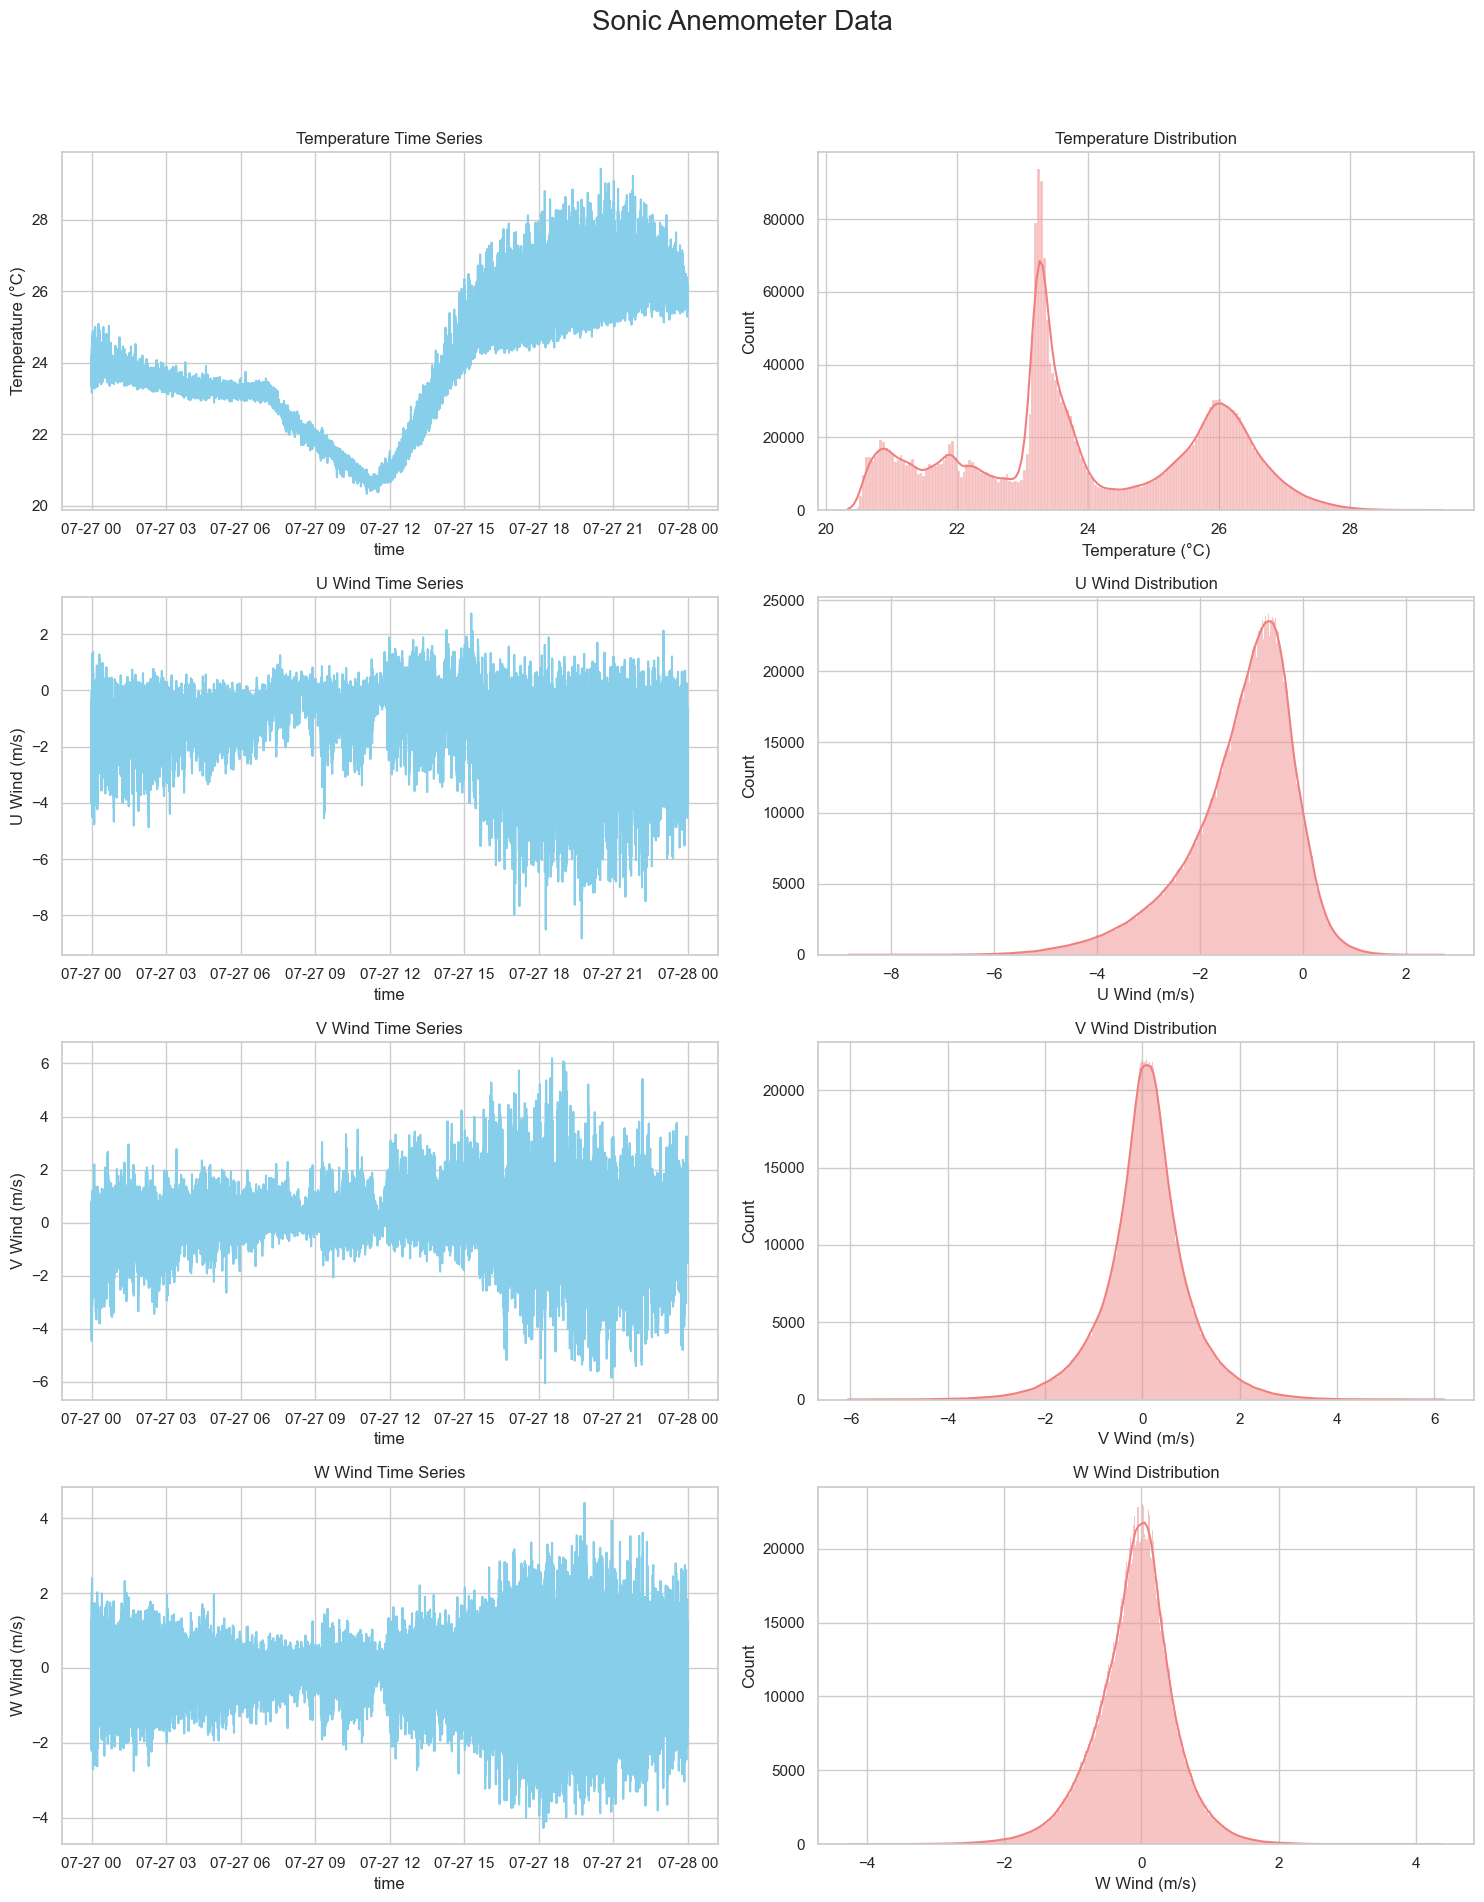

In [ ]:

sns.set(style="whitegrid")

fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Sonic Anemometer Data', fontsize=20)

# time series
sns.lineplot(x='time', y='temp', data=df, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Temperature Time Series')
axes[0, 0].set_ylabel('Temperature (°C)')

sns.lineplot(x='time', y='uwind', data=df, ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('U Wind Time Series')
axes[1, 0].set_ylabel('U Wind (m/s)')

sns.lineplot(x='time', y='vwind', data=df, ax=axes[2, 0], color='skyblue')
axes[2, 0].set_title('V Wind Time Series')
axes[2, 0].set_ylabel('V Wind (m/s)')

sns.lineplot(x='time', y='wwind', data=df, ax=axes[3, 0], color='skyblue')
axes[3, 0].set_title('W Wind Time Series')
axes[3, 0].set_ylabel('W Wind (m/s)')


# histograms
sns.histplot(df['temp'], ax=axes[0, 1], color='lightcoral', kde=True)
axes[0, 1].set_title('Temperature Distribution')
axes[0, 1].set_xlabel('Temperature (°C)')

sns.histplot(df['uwind'], ax=axes[1, 1], color='lightcoral', kde=True)
axes[1, 1].set_title('U Wind Distribution')
axes[1, 1].set_xlabel('U Wind (m/s)')

sns.histplot(df['vwind'], ax=axes[2, 1], color='lightcoral', kde=True)
axes[2, 1].set_title('V Wind Distribution')
axes[2, 1].set_xlabel('V Wind (m/s)')

sns.histplot(df['wwind'], ax=axes[3, 1], color='lightcoral', kde=True)
axes[3, 1].set_title('W Wind Distribution')
axes[3, 1].set_xlabel('W Wind (m/s)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### More plots
A generative model created this code for plotting turbulence_intensity after several attempts (Please verify before using).

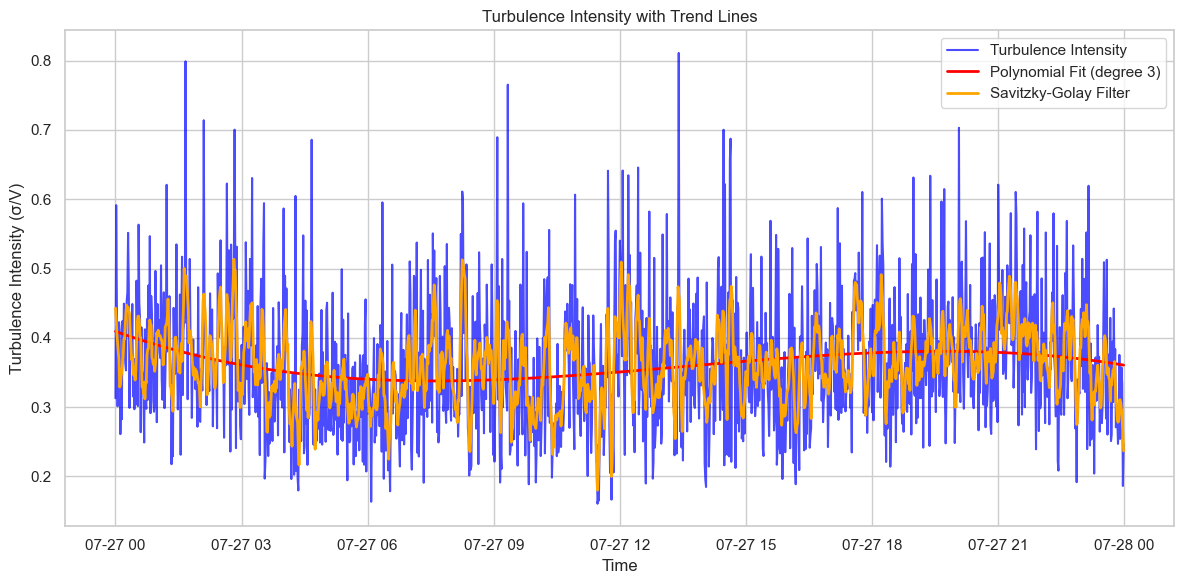

In [40]:
def calculate_turbulence_intensity(ds, interval='1min'):
    # Calculate wind speed
    if all(var in ds for var in ['uwind', 'vwind', 'wwind']):
        wind_speed = np.sqrt(ds.uwind**2 + ds.vwind**2 + ds.wwind**2)
    else:
        print(f"Wind components (uwind, vwind, wwind) not found in dataset")
        print(f"Available variables: {list(ds.data_vars)}")
        return None

    time_values = pd.to_datetime(ds.time.values, unit='ns')
    
    df = pd.DataFrame({
        'wind_speed': wind_speed.values
    }, index=time_values)
    
    resampled = df.resample(interval)
    std_dev = resampled.std()
    mean_wind = resampled.mean()
    
    turbulence_df = pd.DataFrame({
        'std_dev': std_dev['wind_speed'],
        'mean_wind': mean_wind['wind_speed']
    })
    
    # avoiding division by zero
    turbulence_df['turbulence_intensity'] = np.where(
        turbulence_df['mean_wind'] > 0,
        turbulence_df['std_dev'] / turbulence_df['mean_wind'],
        np.nan
    )
    
    return turbulence_df

# Calculate turbulence intensity
turbulence_df = calculate_turbulence_intensity(ds, interval='1min')

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(turbulence_df.index, turbulence_df['turbulence_intensity'], 
         label='Turbulence Intensity', color='blue', alpha=0.7)

# Clean data before fitting
# Remove NaN values
clean_df = turbulence_df.dropna(subset=['turbulence_intensity'])

if not clean_df.empty:
    # Scale the x-values to avoid numerical issues
    # Convert datetime to normalized time values (0 to 1)
    x_data = np.array((clean_df.index - clean_df.index.min()).total_seconds())
    x_norm = (x_data - x_data.min()) / (x_data.max() - x_data.min() + 1e-10)
    y_data = clean_df['turbulence_intensity'].values
    
    # Use a lower degree polynomial (3 instead of 5)
    poly_degree = 3
    coefficients = np.polyfit(x_norm, y_data, deg=poly_degree)
    polynomial = np.poly1d(coefficients)
    
    # Create evenly spaced x values for the smooth curve
    x_fit = np.linspace(0, 1, 100)
    y_fit = polynomial(x_fit)
    
    # Convert back to original datetime scale for plotting
    time_min = clean_df.index.min()
    time_max = clean_df.index.max()
    fit_times = [time_min + pd.Timedelta(seconds=x * (time_max - time_min).total_seconds()) 
                for x in x_fit]
    
    # Plot the smoothed curve
    plt.plot(fit_times, y_fit, color='red', linewidth=2, 
             label=f'Polynomial Fit (degree {poly_degree})')

    # Alternative: Use LOWESS smoothing
    from scipy.signal import savgol_filter
    if len(y_data) > 10:  # Need enough points for smoothing
        window_length = min(11, len(y_data) - (len(y_data) % 2) - 1)  # Must be odd
        if window_length >= 3:
            y_smooth = savgol_filter(y_data, window_length, 2)
            plt.plot(clean_df.index, y_smooth, color='orange', linewidth=2, 
                     label='Savitzky-Golay Filter')

# Labels and legend
plt.xlabel("Time")
plt.ylabel("Turbulence Intensity (σ/V)")
plt.title("Turbulence Intensity with Trend Lines")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

jupyter trust /Users/bhupendra/git_repo/instrument-cookbooks/notebooks/adm-3dsonic/download_ADM-sonic3d_toNC_plot.ipynb
Signing notebook: /Users/bhupendra/git_repo/instrument-cookbooks/notebooks/adm-3dsonic/download_ADM-sonic3d_toNC_plot.ipynb